# MuchLearningSuchWow - LSTM - Training

This notebook contains the code we used to define and train our LSTM network. The training code is based primarily on [this kernel](https://www.kaggle.com/bountyhunters/baseline-lstm-with-keras-0-7).

### Imports & Data Paths

In [1]:
import numpy as np
import pandas as pd
import pickle

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, Callback
from keras.optimizers import Adam

import keras.backend as K
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
outputPath = "output/"
modelPath = "models/"

### Constants

In [3]:
timesteps = 14 # Number of previous days that will be used to predict the next day
startDay = 1000 # Number of days at start of data that will be ignored during training
trainValDays = 28 # Number of days at the end of the training data that will be set aside for validation during training

### Loading Data

In [4]:
with open(outputPath + "/preprocessed_train_valid_data.pkl", "rb") as f:
    df_train_valid = pickle.load(f)
with open(outputPath + "/scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

In [5]:
df_train = df_train_valid[:-28] # Remove validation data (the Kaggle validation data, not the part we set aside ourselves)
print(df_train.shape)

(913, 30492)


In [6]:
df_train_scaled = scaler.transform(df_train) # Scale the training data

### Create Training/Validation Data and Labels

In [7]:
X_train = []
y_train = []
for i in range(timesteps, 1913 - startDay - trainValDays):
    X_train.append(df_train_scaled[i-timesteps:i])
    y_train.append(df_train_scaled[i][0:30490]) # Only use first 30490 columns (sales) as labels

X_valid = []
y_valid = []
for i in range(1913-startDay-trainValDays, 1913-startDay):
    X_valid.append(df_train_scaled[i-timesteps:i])
    y_valid.append(df_train_scaled[i][0:30490]) # Only use first 30490 columns (sales) as labels

In [8]:
del df_train_scaled

In [9]:
# Convert data to np array to be able to feed it to the model
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)
print(y_train.shape)

X_valid = np.array(X_valid)
y_valid = np.array(y_valid)
print(X_valid.shape)
print(y_valid.shape)

(871, 14, 30492)
(871, 30490)
(28, 14, 30492)
(28, 30490)


### LSTM Model

In [10]:
model = Sequential()

# 1D convolution layer
model.add(Conv1D(filters=32, kernel_size=7, strides=1, padding="causal",activation="relu",input_shape=(X_train.shape[1], X_train.shape[2])))

# LSTM layers
layer_1_units=150
model.add(LSTM(units = layer_1_units, return_sequences = True))
model.add(Dropout(0.1))

layer_2_units=300
model.add(LSTM(units = layer_2_units, return_sequences = True))
model.add(Dropout(0.1))

layer_3_units=400
model.add(LSTM(units = layer_3_units))
model.add(Dropout(0.1))

# Output layer
model.add(Dense(units = 30490))

In [11]:
plot_model(model, modelPath + "/model.png")
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 14, 32)            6830240   
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 150)           109800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 150)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 14, 300)           541200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 300)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 400)               1121600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 400)              

### Training

In [12]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Compiling the model
model.compile(optimizer = Adam(learning_rate=0.001), loss = root_mean_squared_error)

# Fitting the model to the training set
nr_epochs = 50
batch_size = 16

# Saving model with lowest validation loss
mcp_save = ModelCheckpoint(modelPath + "/lstm_model_best", save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(X_train, y_train, 
                    epochs = nr_epochs, 
                    validation_data = (X_valid, y_valid), 
                    batch_size = batch_size, 
                    verbose=1, 
                    callbacks = [mcp_save])

Train on 871 samples, validate on 28 samples
Epoch 1/50
871/871 [==============================] - 33s 38ms/step - loss: 0.1471 - val_loss: 0.1584
Epoch 2/50
871/871 [==============================] - 30s 35ms/step - loss: 0.1417 - val_loss: 0.1574
Epoch 3/50
871/871 [==============================] - 29s 34ms/step - loss: 0.1399 - val_loss: 0.1557
Epoch 4/50
871/871 [==============================] - 30s 34ms/step - loss: 0.1381 - val_loss: 0.1569
Epoch 5/50
871/871 [==============================] - 29s 34ms/step - loss: 0.1367 - val_loss: 0.1543
Epoch 6/50
871/871 [==============================] - 29s 34ms/step - loss: 0.1357 - val_loss: 0.1544
Epoch 7/50
871/871 [==============================] - 29s 34ms/step - loss: 0.1351 - val_loss: 0.1548
Epoch 8/50
871/871 [==============================] - 29s 33ms/step - loss: 0.1344 - val_loss: 0.1546
Epoch 9/50
871/871 [==============================] - 29s 34ms/step - loss: 0.1338 - val_loss: 0.1524
Epoch 10/50
871/871 [================

### Saving Result

In [13]:
model.save(modelPath + "/lstm_model_final")

### Plotting Losses

In [14]:
def plot_loss(history, nr_epochs, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, nr_epochs), history.history['loss'], label='train_loss')
    plt.plot(np.arange(0, nr_epochs), history.history['val_loss'], label='val_loss')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

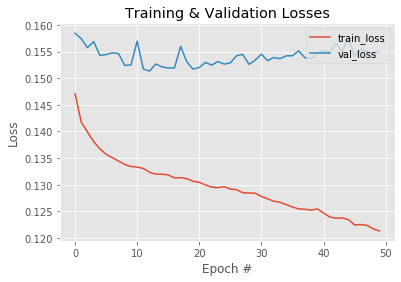

In [15]:
plot_loss(history, nr_epochs, 'Training & Validation Losses')